# Chemprot Shortcut analysis

In [1]:
s3_test_prediction = "s3://aegovan-data/chemprot/predictions_chemprot-bert-f1-2022-05-22-23-18-21-560/prediction_chemprot_test.json"
s3_train_prediction = "s3://aegovan-data/chemprot/predictions_chemprot-bert-f1-2022-05-22-23-18-21-560/prediction_chemprot_train.json"
s3_val_prediction = "s3://aegovan-data/chemprot/predictions_chemprot-bert-f1-2022-05-22-23-18-21-560/prediction_chemprot_dev.json"



participants_to_replace = {
    "_GENE-Y_" : "_GENE_",
    "_GENE-N_" : "_GENE_"
}



x_column = "sentence_anonymised"
gold_y_column = "label"
prediction_y_column = "prediction"




In [2]:
s3_test_prediction ="s3://aegovan-data/chemprot/predictions_chemprot-abstract-bert-f1-2022-07-30-22-34-07-969/prediction_chemprot_abstract_test_marker.json"
s3_val_prediction ="s3://aegovan-data/chemprot/predictions_chemprot-abstract-bert-f1-2022-07-30-22-34-07-969/prediction_chemprot_abstract_val_marker.json"
s3_train_prediction ="s3://aegovan-data/chemprot/predictions_chemprot-abstract-bert-f1-2022-07-30-22-34-07-969/prediction_chemprot_abstract_train_marker.json"

s3_largescale_high_quality_prediction = "s3://aegovan-data/chemprot/predictions_chemprot-abstract-bert-f1-2022-07-30-22-34-07-969/2022080621_negative_generalisation/highquality_sample.json"
s3_largescale_low_quality_prediction = "s3://aegovan-data/chemprot/predictions_chemprot-abstract-bert-f1-2022-07-30-22-34-07-969/2022080621_negative_generalisation/lowquality_sample.json"




x_column = "x"
gold_y_column = "y_raw"
prediction_y_column = "prediction"
participants_to_replace = {
    "GENEPART0" : "_GENE_",
    "GENEPART1" : "_GENE_",
    "CHEMPART1" : "_CHEMICAL_",
    "CHEMPART0" : "_CHEMICAL_",


}


In [3]:
other_genes_to_replace = {f"GENEIG{i} ":"_OTHER_ " for i in range(20)}
other_chem_to_replace = {f"CHEMIG{i} ":"_OTHER_ " for i in range(20)}

other_ignore = {**other_genes_to_replace, **other_chem_to_replace}

# markers_to_replace = {**participants_to_replace, **other_ignore }
markers_to_replace = {**participants_to_replace}

In [4]:
markers_to_replace

{'GENEPART0': '_GENE_',
 'GENEPART1': '_GENE_',
 'CHEMPART1': '_CHEMICAL_',
 'CHEMPART0': '_CHEMICAL_'}

#### Get the gold dataset from https://biocreative.bioinformatics.udel.edu/media/store/files/2017/ChemProt_Corpus.zip

In [5]:
s3_test_gold_file = "s3://aegovan-data/chemprotner/test/chemprot_test_gold_standard.tsv"

In [6]:
import sys, pandas as pd, os, matplotlib.pyplot as plt, sklearn
from sklearn import tree

sys.path.append("../src")


label_names = ["NEGATIVE",
                            "CPR:3",
                            "CPR:4",
                            "CPR:5",
                            "CPR:6",
                            "CPR:9"]

all_labels = list(range(len(label_names)))
pos_labels = list(range(1, len(label_names)))

trigger_words =  ["induced", "activator","upregulator" , "inhibitor","downregulator" , "agonist", "kinase","regulator","modulator"]



In [7]:
import sys, os, pandas as pd
pd.set_option('display.max_colwidth',None)


sys.path.append("../src")

from utils.s3_utils import download_file as download_s3_file

## Download prediction

In [8]:
local_temp= "temp"

In [9]:
local_prediction_dir = os.path.join(local_temp, "prediction")
os.makedirs(local_prediction_dir, exist_ok=True)
local_test_prediction_file  = download_s3_file( s3_test_prediction, local_prediction_dir)
local_train_prediction_file  = download_s3_file( s3_train_prediction, local_prediction_dir)
local_val_prediction_file  = download_s3_file( s3_val_prediction, local_prediction_dir)
test_gold_file  = download_s3_file( s3_test_gold_file, local_prediction_dir)
local_highquality_file = download_s3_file(s3_largescale_high_quality_prediction, local_prediction_dir)
local_lowquality_file = download_s3_file(s3_largescale_low_quality_prediction, local_prediction_dir)





## Utils

In [10]:
def add_key_column(df):
    df["key"] = df.apply(lambda x:"{}#{}#{}".format( x["abstract_id"], x["participant1_id"].replace("Arg1:",""), x["participant2_id"].replace("Arg2:","")), axis=1)
    return df

def load_gold(file):
    df = pd.read_csv(file, delimiter="\t", header=None, names = ["abstract_id", "relationship_type", "participant1_id","participant2_id"])
    
    return df

In [11]:

def replace_in_place(x, replacement_dict):
    for k,v in replacement_dict.items():
        x = x.replace(k,v)
    return x
    

def load_valtest_pred(file, labels_order = label_names, markers_replacement=markers_to_replace):
    df = pd.read_json(file, orient="records")
    
    

    df["x"] = df[x_column].apply(lambda x: replace_in_place(x,markers_replacement))
    df["gold"] = df[gold_y_column].apply(lambda x: labels_order.index(x))
    df["gold_raw"] = df[gold_y_column]

    df["y"] = df[prediction_y_column].apply(lambda x: labels_order.index(x))
    df["y_raw"] = df[prediction_y_column]


    #df = df.query("is_eval == 'Y'").copy()

    return df

In [12]:
from model_nb_relation_classifier import ModelNBRelationClassifier
from model_nb_tree_relation_classifier import ModelNBTreeRelationClassifier
from model_tree_relation_classifier import ModelTreeRelationClassifier

NAIVE_BAYES="Naive Bayes"
NAIVE_BAYES_WITH_TREE = "Naive Bayes + Tree"
TREE = "Tree"

def  train_and_predict_all_classifiers(df, min_df=None, ngram_range=(1,1), stop_words = 'english', classifiers={NAIVE_BAYES, NAIVE_BAYES_WITH_TREE}, max_words_per_class=5000, classwise_vocab=True):
    
    max_tree_depth = 8
    min_df = min_df or 3
    
   
    
    classifiers_map = {
        NAIVE_BAYES : ModelNBRelationClassifier("_CHEMICAL_", "_GENE_", min_df=min_df, max_words_per_class=max_words_per_class, stop_words=stop_words, ngram_range=ngram_range, classwise_vocab=classwise_vocab),
        NAIVE_BAYES_WITH_TREE : ModelNBTreeRelationClassifier("_CHEMICAL_", "_GENE_", min_df=min_df,  max_words_per_class=max_words_per_class,trigger_words=trigger_words, max_tree_depth = max_tree_depth ),
        TREE : ModelTreeRelationClassifier("_CHEMICAL_", "_GENE_", trigger_words=trigger_words, max_tree_depth = max_tree_depth)

    }
    
    result = {}
    for k in filter(lambda x: x in classifiers,  classifiers_map):
    
        m = classifiers_map[k]
        
        print(f"Training {k}")
        
        m.train(df["x"], df["y"])
        p, p_conf = m.predict(df["x"])
        result[k] = {
            "m" : m,
            "predictions" : p,
             "predictions_conf": p_conf
        }
    return result


def  predict_all_classifiers(df, models_dict):
   
    
   
    
    result = {}
    for k, v in models_dict.items():
        m = v["m"]
        
        p, p_conf = m.predict(df["x"])
        result[k] = {
            "m" : m,
            "predictions" : p,
            "predictions_conf": p_conf
        }
    return result




In [13]:
import tempfile

def isint(a):
    try:
        t = int(a)
        return True
    except:
        return False

def float_percent_format(x):
     return "{:.1f}".format(x*100)

def int_format(x):
     return str(int(x))

def print_report(actual, pred, labels=None, label_names = all_labels):

    pos_f1 = sklearn.metrics.f1_score(actual, pred, labels=labels, average='micro',
                                  sample_weight=None, zero_division=0)
    all_f1 = sklearn.metrics.f1_score(actual, pred, average='micro', sample_weight=None, zero_division=0)
    
    
    
  
        
    d = sklearn.metrics.classification_report(actual,
                                            pred,
                                            output_dict=True,
                                            labels=labels,zero_division=0)
    df =  pd.DataFrame(d).T
    df.index = list(map(lambda x: label_names[int(x)] if isint( x) else x, df.index))

    return df
    

def print_report_all_classifiers(actual, results_dict, *args, **kwargs):
    result = []
    for k, v in results_dict.items():
        df = print_report(actual,v["predictions"],  *args, **kwargs)
        df.insert (0, "model", k)
        
        result.append(df)
    df = pd.concat(result)
    df.insert(1, "index", df.index)
    print(df.to_latex(index=False, formatters = {"precision": float_percent_format, "recall":float_percent_format, "f1-score":float_percent_format,"support":int_format }))
    return df    
    

In [14]:
    
import subprocess

def _write_chemprot_eval(df,y_col, dest_file):
   
    df = df[["abstract_id",y_col, "participant1_id", "participant2_id"]].query(f"{y_col} != 'NEGATIVE' ").copy(deep=True)
    

    df["participant1_id"] = df["participant1_id"].apply(lambda x: f"Arg1:{x}")
    df["participant2_id"] = df["participant2_id"].apply(lambda x: f"Arg2:{x}")
    df.to_csv(dest_file, sep="\t", header=False, index=False)

    
def _run_shell( cmd):
        """
        Runs a shell command
        :param cmd: The cmd to run
        """
        print("Running command\n{}".format(" ".join(cmd)))

        out = subprocess.Popen(
            cmd,
            stdout=subprocess.PIPE,
            stderr=subprocess.STDOUT)
        stdout, stderr = out.communicate()
        result = stdout.decode(encoding='utf-8')
        if stderr:
            error_msg = stderr.decode(encoding='utf-8')
            print(error_msg)
            raise Exception(error_msg)

        return result
    
def print_report_original(df,y_col, gold_file, latex=True,  jar_path="../thirdparty"):
   
    # Run original eval script to double check numbers
    _, pred_file = tempfile.mkstemp()
    _write_chemprot_eval(df,y_col, pred_file)
    output_dir = "out"
    os.makedirs(output_dir, exist_ok = True)
    cmd = ["java", "-cp" , f"{jar_path}/bc6chemprot_eval.jar", "org.biocreative.tasks.chemprot.main.Main",
           "-TP", "TRUE", "-FP", "TRUE", "-FN", "TRUE", pred_file, gold_file]
    cmd_result = _run_shell(cmd)
    print(cmd_result)

    # Result summary written to eval .txt
    with open(os.path.join(output_dir,"eval.txt"), "r") as f:
        result = f.readlines()
        print(result)
        
    # Parse detailed output file to obtain classwise stats
    names = ["abstract_id", "y", "participant1_id", "participant2_id"]
    df_fp = pd.read_csv(os.path.join(output_dir,"fp.txt"),sep="\t", header=None, names=names)
    df_fp["c"] ="FP"
    df_fn = pd.read_csv(os.path.join(output_dir,"fn.txt"),sep="\t", header=None, names=names)
    df_fn["c"] ="FN"
    df_tp = pd.read_csv(os.path.join(output_dir,"tp.txt"),sep="\t", header=None, names=names)
    df_tp["c"] ="TP"
    df = pd.concat([df_fp, df_tp, df_fn])
    
    df_test_summary = df.groupby(["y" , "c"]).size()\
                .reset_index().rename(columns={0:"total"})\
                .pivot(index="y", columns="c", values="total")
    df_test_summary.loc["total", "FN"] = df_test_summary["FN"].sum()
    df_test_summary.loc["total", "FP"] = df_test_summary["FP"].sum()
    df_test_summary.loc["total", "TP"] = df_test_summary["TP"].sum()

    df_test_summary["P"] = df_test_summary["TP"].div(df_test_summary["TP"] + df_test_summary["FP"])
    df_test_summary["R"] = df_test_summary["TP"].div(df_test_summary["TP"] + df_test_summary["FN"])
    df_test_summary["F"] = (2*df_test_summary["P"] * df_test_summary["R"]).div(df_test_summary["P"] +df_test_summary["R"])


    
    # Clean up
    os.remove(pred_file)
    return df_test_summary

In [15]:
def plot_tree(m):
    _, ax = plt.subplots(1,1, figsize=(45,15))

    tree.plot_tree(m.tree_model, ax=ax, fontsize=10, feature_names=m.feature_names)

    plt.show()

In [16]:
def get_top_discrimintary_keywords(model, label_index ) :
    index_to_vocab = {i:v  for v,i in model.vocab.items()}

    return sorted( [ (index_to_vocab[i],p) for i,p in enumerate(model.nb_model.feature_log_prob_[label_index])], 
           reverse=True, key=lambda x: x[1])




In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def consolidate_label_names(actual, pred, label_names):
    label_indices = list(set(actual).union(pred))
    return [label_names[i] for i in sorted(label_indices)]

def plot_confusionmatrix(y_true,y_pred, normalize=None):
    cm = confusion_matrix(y_true,y_pred, normalize=normalize)
    labels = consolidate_label_names( y_true,y_pred,label_names)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = labels)
    disp.plot(cmap="PuBu", xticks_rotation="vertical")

In [18]:
import math
from scipy.spatial import distance


def _build_list(l1,l2, use_common_only=True):
    word_index = {w:i for i,(w,p) in enumerate(l1)}
    for w,_ in l2:
        if w not in word_index: word_index[w]=len(word_index)
           
    if use_common_only:
        intersection = set([w for w,_ in l2]).intersection(set([w for w,_ in l1]))
        word_index = {w:i for i,w in enumerate(intersection)}


    
    l1_r = [0.00000000   for _ in range(len(word_index))]
    for i, (w,p) in enumerate( filter(lambda x:x[0] in word_index ,l1)):        
        l1_r[word_index[w] ] = math.exp(p)
        
    l2_r = [0.00000000   for _ in range(len(word_index))]
    for i, (w,p) in enumerate( filter(lambda x:x[0] in word_index ,l2)):
        l2_r[word_index[w] ] = math.exp(p)
    
    return l1_r,l2_r

def js_divergence(p_keyword, q_keyword, use_common_only=True):
    p,q = _build_list(p_keyword, q_keyword, use_common_only=use_common_only)
    return distance.jensenshannon(p,q, 2)

def kl_divergence(p_keyword, q_keyword, use_common_only=True):
    p,q = _build_list(p_keyword, q_keyword, use_common_only=use_common_only)
    return sum(p[i] * math.log(p[i]/q[i]) for i in range(len(p)))

In [19]:
import scipy

def jaccard(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

# def compare_discrimintary_keywords(nb_m1,nb_m2, label_index):
#     list1 = [w for w,s in get_top_discrimintary_keywords(nb_m1, label_index)]
#     list2 = [w for w,s in get_top_discrimintary_keywords(nb_m2, label_index)]
#     max_size = min(len(list1), len(list2))
#     print(jaccard(list1[:max_size], list2[:max_size]))
#     print(scipy.stats.kendalltau(list1[:max_size], list2[:max_size]))
#     return scipy.stats.kendalltau(list1[:max_size], list2[:max_size])




In [20]:
def filter_eval(df):
    return df[df["is_eval"].apply(lambda r: r == 'Y')].copy() 

def add_unique_genes_chem(df):
    df["unique_chemprot_names"] = df["annotations"].apply(lambda x: sorted(list(set([ i["entity_name"] for i in x]))))
    return df



def extract_span(item: str, marker1: str, marker2: str):
    def _swap( marker1, marker2):
        return marker2, marker1

    m1 = item.find(marker1)
    m2 = item.find(marker2)
    
    # m1 occurs first
    if m1 > m2:
        marker1, marker2 = _swap(marker1, marker2)

    m1_start = item.find(marker1)

    m1_end = item.rfind(marker1)
    m2_end = item.rfind(marker2)

    end = m1_end + len(marker1) if m1_end > m2_end else m2_end + len(marker2)

    return item[m1_start: end]


def add_span_genes_chem(df):
    df["x_span"] = df["x"].apply(lambda x: extract_span(x, "_GENE_", "_CHEMICAL_"))
    df["x_span_word_len"] = df["x_span"].apply(lambda x: len(x.split(" ")))
    return df

def filter_include_min_word_len(df, min_len=5):
    return df.query(f"x_span_word_len > {min_len}").copy()

def filter_include_max_word_len(df, max_len=15):
    return df.query(f"x_span_word_len <= {max_len}").copy()




## Train GT Train predictions

In [21]:
df_train = load_valtest_pred(local_train_prediction_file)\
                .pipe(add_unique_genes_chem)\
                .pipe(add_span_genes_chem)


In [22]:
train_result = train_and_predict_all_classifiers(df_train, min_df=1)



print_report_all_classifiers(df_train["gold"],train_result, labels=all_labels)

Training Naive Bayes
Max words :  2889
Training Naive Bayes + Tree
\begin{tabular}{llrrrr}
\toprule
             model &        index & precision & recall & f1-score & support \\
\midrule
       Naive Bayes &            0 &      80.6 &   63.6 &     71.1 &    2265 \\
       Naive Bayes &            1 &      74.2 &   61.5 &     67.3 &     777 \\
       Naive Bayes &            2 &      59.0 &   91.2 &     71.7 &    2260 \\
       Naive Bayes &            3 &      81.4 &   20.2 &     32.4 &     173 \\
       Naive Bayes &            4 &      73.1 &   24.3 &     36.4 &     235 \\
       Naive Bayes &            5 &      88.1 &   47.7 &     61.9 &     727 \\
       Naive Bayes &     accuracy &      68.6 &   68.6 &     68.6 &       0 \\
       Naive Bayes &    macro avg &      76.1 &   51.4 &     56.8 &    6437 \\
       Naive Bayes & weighted avg &      72.9 &   68.6 &     67.5 &    6437 \\
Naive Bayes + Tree &            0 &      81.0 &   65.7 &     72.6 &    2265 \\
Naive Bayes + Tree &  

,model,index,precision,recall,f1-score,support
0,Naive Bayes,0,0.806271,0.635762,0.710936,2265.000000
1,Naive Bayes,1,0.742236,0.615187,0.672766,777.000000
2,Naive Bayes,2,0.590493,0.912389,0.716968,2260.000000
3,Naive Bayes,3,0.813953,0.202312,0.324074,173.000000
4,Naive Bayes,4,0.730769,0.242553,0.364217,235.000000
5,Naive Bayes,5,0.880711,0.477304,0.619090,727.000000
accuracy,Naive Bayes,accuracy,0.686500,0.686500,0.686500,0.686500
macro avg,Naive Bayes,macro avg,0.760739,0.514251,0.568008,6437.000000
weighted avg,Naive Bayes,weighted avg,0.728640,0.686500,0.675018,6437.000000
0,Naive Bayes + Tree,0,0.809679,0.657395,0.725634,2265.000000


In [23]:
df_train.query("gold_raw == 'NEGATIVE'").head()

x  \
19                                                                                                                                                                                                                                                                                        New aspects in the management of obesity: operation and the impact of GENEIG0 inhibitors. Obesity is an increasing health problem in most developed countries and its prevalence is also increasing in developing countries. There has been no great success with dietary means and life style modification for permanent weight loss. Various surgical treatment methods for obesity are now available. They are aimed at limiting oral energy intake with or without causing dumping or inducing selective maldigestion and malabsorption. Based on current literature, up to 75% of excess weight is lost by surgical treatment with concomitant disappearance of hyperlipidaemias, type 2 diabetes, hypertension or sleep apnoea. The main indication for operative treatment is morbid obesity (body mass index greater than 40 kg/m2) or severe obesity (body mass index > 35 kg/m2) with comorbidities of obesity. CHEMIG6 is a new inhibitor of GENEIG4 enzyme. At doses of 120 mg three times per day with meals it results in a 30% reduction in dietary fat absorption, which equals approximately 200 kcal daily energy deficit. In the long term, CHEMIG1 has been shown to be more effective than placebo in reducing body weight and serum total and GENEIG5 CHEMIG3 levels. CHEMIG6 has a lowering effect on serum CHEMIG3 independent of weight loss. Along with weight loss, _CHEMICAL_ also favourably affects blood pressure and CHEMIG2 and _GENE_ levels in obese individuals and in obese type 2 diabetic patients.   
22     CHEMIG15 suppress activation of microglia: down-regulation of GENEIG16 by CHEMIG8. Mechanisms leading to down-regulation of activated microglia and astrocytes are poorly understood, in spite of the potentially detrimental role of activated glia in neurodegeneration. CHEMIG13, produced both by neurons and glia, may serve as mediators of glial and neuronal functions. We examined the influence of CHEMIG2 and their precursors on activated glia. As models of glial activation, production of GENEIG16 (GENEIG6) was studied in lipopolysaccharide-stimulated rat microglia, a murine microglial cell line BV-2, and GENEIG7-stimulated rat astrocytes. CHEMIG15 were potent inhibitors of GENEIG6 induction and were more effective than their precursors, CHEMIG0. CHEMIG9 (CHEMIG1) was the most potent CHEMIG3 among those tested. In activated microglia, CHEMIG1 suppressed GENEIG12 activity, GENEIG6 mRNA, and protein levels. The action of _CHEMICAL_ does not appear to involve its nuclear receptor _GENE_ (GENEIG5) because CHEMIG10, a specific ligand of GENEIG5, was unable to inhibit GENEIG6 induction, and neither CHEMIG10 nor CHEMIG1 could stimulate the activity of a GENEIG14-dependent promoter in the absence of cotransfected GENEIG5. CHEMIG1 did not block nuclear translocation or DNA-binding activity of the transcription factor GENEIG11, but it did inhibit the activity of an GENEIG11 reporter construct, suggesting that the mechanism of suppression of microglial GENEIG6 by CHEMIG1 may involve interference with GENEIG11 transcriptional activity in the nucleus. Thus, our data suggest the existence of a novel pathway mediated by CHEMIG2, which may represent part of a feedback mechanism leading to the cessation of inflammatory glial responses in the brain.   
23  CHEMIG4 suppress activation of microglia: down-regulation of GENEIG12 by CHEMIG7. Mechanisms leading to down-regulation of activated microglia and astrocytes are poorly understood, in spite of the potentially detrimental role of activated glia in neurodegeneration. CHEMIG17, produced both by neurons and glia, may serve as mediators of glial and neuronal functions. We examined the influence of CHEMIG2 and their precursors on activated glia. As models o

<AxesSubplot:ylabel='Frequency'>

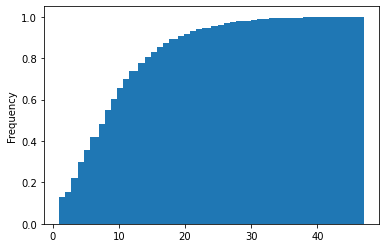

In [24]:
df_train["x_span_word_len"].plot.hist(bins=100, cumulative=True, density=True)

In [25]:
df_train.groupby("gold_raw")["x_span_word_len"].describe(percentiles=[.25,.5,.75,.90])

,count,mean,std,min,25%,50%,75%,90%,max
gold_raw,,,,,,,,,
CPR:3,777.0,10.584299,7.530242,1.0,5.0,9.0,14.0,20.0,45.0
CPR:4,2260.0,9.400442,7.070147,1.0,4.0,8.0,13.0,19.0,43.0
CPR:5,173.0,8.317919,7.442616,1.0,3.0,6.0,11.0,20.8,37.0
CPR:6,235.0,6.442553,7.202793,1.0,2.5,4.0,7.5,17.0,36.0
CPR:9,727.0,7.969739,6.667149,1.0,2.0,7.0,11.0,18.0,31.0
NEGATIVE,2265.0,9.568653,7.429337,1.0,4.0,8.0,13.0,19.6,47.0


<AxesSubplot:ylabel='Frequency'>

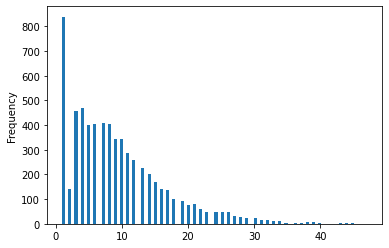

In [26]:
df_train["x_span_word_len"].plot.hist(bins=100)

In [27]:
df_train_filter = df_train\
                    .pipe(add_span_genes_chem)\
                    .pipe(filter_include_min_word_len)


train_result_filter = train_and_predict_all_classifiers(df_train_filter, min_df=1)


print_report_all_classifiers(df_train_filter["gold"],train_result_filter, labels=all_labels)

Training Naive Bayes
Max words :  2831
Training Naive Bayes + Tree
\begin{tabular}{llrrrr}
\toprule
             model &        index & precision & recall & f1-score & support \\
\midrule
       Naive Bayes &            0 &      85.1 &   79.1 &     82.0 &    1506 \\
       Naive Bayes &            1 &      73.0 &   73.9 &     73.4 &     555 \\
       Naive Bayes &            2 &      77.2 &   90.7 &     83.4 &    1491 \\
       Naive Bayes &            3 &      82.4 &   32.2 &     46.3 &      87 \\
       Naive Bayes &            4 &      72.3 &   43.6 &     54.4 &      78 \\
       Naive Bayes &            5 &      90.5 &   73.4 &     81.1 &     414 \\
       Naive Bayes &     accuracy &      80.4 &   80.4 &     80.4 &       0 \\
       Naive Bayes &    macro avg &      80.1 &   65.5 &     70.1 &    4131 \\
       Naive Bayes & weighted avg &      80.9 &   80.4 &     80.0 &    4131 \\
Naive Bayes + Tree &            0 &      82.8 &   74.3 &     78.3 &    1506 \\
Naive Bayes + Tree &  

,model,index,precision,recall,f1-score,support
0,Naive Bayes,0,0.851322,0.790837,0.819966,1506.000000
1,Naive Bayes,1,0.729537,0.738739,0.734109,555.000000
2,Naive Bayes,2,0.771820,0.907445,0.834155,1491.000000
3,Naive Bayes,3,0.823529,0.321839,0.462810,87.000000
4,Naive Bayes,4,0.723404,0.435897,0.544000,78.000000
5,Naive Bayes,5,0.904762,0.734300,0.810667,414.000000
accuracy,Naive Bayes,accuracy,0.803679,0.803679,0.803679,0.803679
macro avg,Naive Bayes,macro avg,0.800729,0.654843,0.700951,4131.000000
weighted avg,Naive Bayes,weighted avg,0.808621,0.803679,0.799888,4131.000000
0,Naive Bayes + Tree,0,0.828275,0.743028,0.783339,1506.000000


In [28]:
df_train = df_train.pipe(add_span_genes_chem)

In [29]:
df_train.columns

Index(['x', 'y', 'y_raw', 'abstract_id', 'abstract', 'annotations',
       'prediction', 'confidence', 'is_eval', 'relationship_type',
       'relationship_group', 'participant1_id', 'participant2_id', 'gold',
       'gold_raw', 'unique_chemprot_names', 'x_span', 'x_span_word_len'],
      dtype='object')

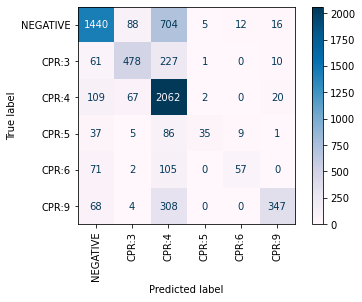

In [30]:
plot_confusionmatrix(df_train["gold"], train_result[NAIVE_BAYES]["predictions"])

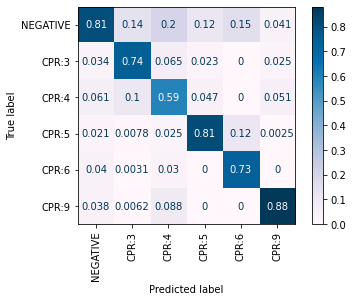

In [31]:
plot_confusionmatrix(df_train["gold"], train_result[NAIVE_BAYES]["predictions"], normalize='pred')

<AxesSubplot:ylabel='Frequency'>

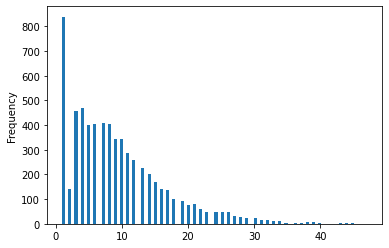

In [32]:
df_train["x_span"].apply(lambda x: len(x.split(" "))).plot.hist(bins=100)

In [33]:
df_train.query("abstract_id == 12850267")[[ "participant1_id", "participant2_id", "x_span","x", "y_raw","gold_raw","unique_chemprot_names","abstract"]]

,participant1_id,participant2_id,x_span,x,y_raw,gold_raw,unique_chemprot_names,abstract
1134,T1,T24,,"Tissue expression and translational control of GENEIG7e/CHEMIG3 transaminase K mRNAs. _CHEMICAL_ (CHEMIG10) is an endogenous CHEMIG4 receptor antagonist at the level of the different GENEIG1. One of the enzymes responsible for the production of CHEMIG10, CHEMIG11 aminotransferase I (GENEIG5), also catalyses the reversible transamination of CHEMIG3 to CHEMIG17 (GENEIG14, GENEIG13). The enzyme exists in a cytosolic and in a mitochondrial form because of the presence of two different GENEIG5 mRNAs coding for a protein respectively with and without GENEIG20 targeting the protein into mitochondria. We have cloned from a phage library of rat kidney cDNA four new GENEIG5 cDNAs containing different GENEIG6 (GENEIG16). One of the transcripts (+14GENEIG5 cDNA) contains an alternative site of initiation of translation. The tissue distribution of the different transcripts was studied by RT-PCR. The study demonstrated that several GENEIG5 mRNAs are constitutively expressed in ubiquitous manner, while +14GENEIG5 mRNA is present only in kidney. The translational efficiency of the different transcripts was studied in vitro and enzymatic activities were measured in transiently transfected Cos-1 cells. Each GENEIG5 mRNA exhibits a different in vitro translational efficiency, which corresponds to different levels of GENEIG18 enzymatic activity in transfected cells. Both findings correlate with the predicted accessibility of the ribosomal binding sites of the different mRNAs. The structure of the GENEIG19/GENEIG14 gene was also studied. The expression of several GENEIG5 mRNAs with different GENEIG9 represents an interesting example of transcriptional/translational control on the expression of CHEMIG12 (CHEMIG15)-dependent aminotransferases.",CPR:6,CPR:6,"[5' untranslated regions, 5'UTRs, EC 2.6.1.15, GTK, KA, KAT, KATI, Kynurenic acid, PLP, UTRs, glutamate, glutamate receptor, glutamine, glutamine transaminase K, ionotropic glutamate receptors, kynurenine, kynurenine aminotransferase I, leader sequence, oxoglutaramic acid, pyridoxal phosphate, pyridoxal phosphate (PLP)-dependent aminotransferases, rat KATI, rat kynurenine aminotransferas]","Tissue expression and translational control of rat kynurenine aminotransferase/glutamine transaminase K mRNAs. Kynurenic acid (KA) is an endogenous glutamate receptor antagonist at the level of the different ionotropic glutamate receptors. One of the enzymes responsible for the production of KA, kynurenine aminotransferase I (KATI), also catalyses the reversible transamination of glutamine to oxoglutaramic acid (GTK, EC 2.6.1.15). The enzyme exists in a cytosolic and in a mitochondrial form because of the presence of two different KATI mRNAs coding for a protein respectively with and without leader sequence targeting the protein into mitochondria. We have cloned from a phage library of rat kidney cDNA four new KATI cDNAs containing different 5' untranslated regions (UTRs). One of the transcripts (+14KATI cDNA) contains an alternative site of initiation of translation. The tissue distribution of the different transcripts was studied by RT-PCR. The study demonstrated that several KATI mRNAs are constitutively expressed in ubiquitous manner, while +14KATI mRNA is present only in kidney. The translational efficiency of the different transcripts was studied in vitro and enzymatic activities were measured in transiently transfected Cos-1 cells. Each KATI mRNA exhibits a different in vitro translational efficiency, which corresponds to different levels of KAT enzymatic activity in transfected cells. Both findings correlate with the predicted accessibility of the ribosomal binding sites of the different mRNAs. The structure of the rat KATI/GTK gene was also studied. The expression of several KATI mRNAs with different 5'UTRs represents an interesting example of transcriptional/translational control on the expression of

In [34]:
df_train.groupby(["abstract_id"])["gold_raw"].unique().apply(frozenset).value_counts()

(NEGATIVE)                                132
(CPR:4)                                   117
(NEGATIVE, CPR:4)                         103
(CPR:4, NEGATIVE, CPR:3)                   65
(NEGATIVE, CPR:3)                          44
(CPR:9)                                    34
(CPR:9, NEGATIVE)                          33
(CPR:4, CPR:3)                             31
(CPR:3)                                    27
(CPR:9, CPR:4)                             27
(CPR:9, NEGATIVE, CPR:4)                   24
(CPR:6)                                    15
(CPR:6, NEGATIVE)                          15
(CPR:5)                                    10
(CPR:5, NEGATIVE)                          10
(CPR:4, CPR:9, NEGATIVE, CPR:3)             8
(CPR:9, NEGATIVE, CPR:3)                    7
(CPR:6, CPR:4)                              7
(CPR:5, CPR:6, NEGATIVE)                    7
(CPR:6, NEGATIVE, CPR:4)                    6
(CPR:4, NEGATIVE, CPR:3, CPR:5, CPR:6)      6
(CPR:5, CPR:6)                    

<AxesSubplot:ylabel='Frequency'>

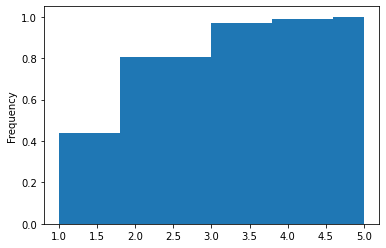

In [35]:
df_train.groupby(["abstract_id"])["gold_raw"].nunique().plot.hist(cumulative=True, density=True)

<AxesSubplot:ylabel='Frequency'>

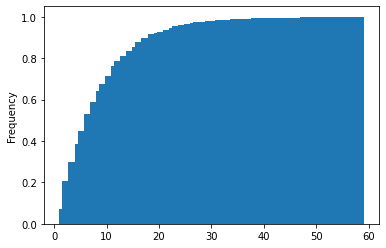

In [36]:
df_train.groupby(["abstract_id"]).size().plot.hist(bins=100, cumulative=True, density=True)

<AxesSubplot:ylabel='Frequency'>

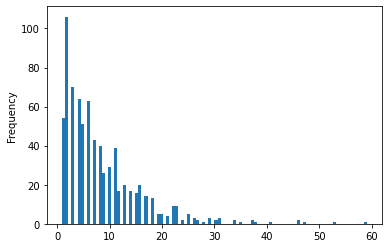

In [37]:
df_train.groupby(["abstract_id"]).size().plot.hist(bins=100)

In [38]:
df_train["abstract_id"].nunique() , 767, 6437

(767, 767, 6437)

In [39]:
df_train["abstract_id"].shape

(6437,)

In [40]:
if TREE in train_result:
    plot_tree(train_result[TREE]["m"])


In [41]:
get_top_discrimintary_keywords(train_result[NAIVE_BAYES]["m"],1)[:50]

[('_gene_', -2.472881547425642),
 ('_chemical_', -2.472881547425642),
 ('increased', -4.195377545787473),
 ('expression', -4.324589277267479),
 ('induced', -4.333247340010593),
 ('increase', -4.721470641684252),
 ('activity', -4.967305604200532),
 ('activation', -5.070846283141372),
 ('significantly', -5.146353835649517),
 ('geneig4', -5.293989834455582),
 ('geneig5', -5.316979352680281),
 ('geneig2', -5.364607401669535),
 ('geneig9', -5.3893000142599075),
 ('geneig3', -5.3893000142599075),
 ('cells', -5.3893000142599075),
 ('geneig10', -5.414617822244197),
 ('geneig1', -5.467261555729619),
 ('phosphorylation', -5.467261555729619),
 ('treatment', -5.494660529917733),
 ('geneig0', -5.494660529917733),
 ('induction', -5.494660529917733),
 ('geneig6', -5.494660529917733),
 ('apoptosis', -5.52283140688443),
 ('geneig7', -5.551818943757682),
 ('geneig8', -5.5816719069073635),
 ('protein', -5.612443565574116),
 ('geneig13', -5.676982086711687),
 ('chemig0', -5.710883638387369),
 ('geneig12',

## Val GT predictions


In [42]:
df_val = load_valtest_pred(local_val_prediction_file)


val_result = train_and_predict_all_classifiers(df_val, min_df=1)




print_report_all_classifiers(df_val["gold"],val_result, labels=pos_labels)

Training Naive Bayes
Max words :  2077
Training Naive Bayes + Tree
\begin{tabular}{llrrrr}
\toprule
             model &        index & precision & recall & f1-score & support \\
\midrule
       Naive Bayes &            1 &      66.3 &   65.6 &     65.9 &     552 \\
       Naive Bayes &            2 &      56.9 &   88.0 &     69.1 &    1103 \\
       Naive Bayes &            3 &      74.4 &   27.6 &     40.3 &     116 \\
       Naive Bayes &            4 &      82.9 &   31.7 &     45.8 &     199 \\
       Naive Bayes &            5 &      84.4 &   53.4 &     65.4 &     457 \\
       Naive Bayes &    micro avg &      62.8 &   68.9 &     65.7 &    2427 \\
       Naive Bayes &    macro avg &      73.0 &   53.2 &     57.3 &    2427 \\
       Naive Bayes & weighted avg &      67.2 &   68.9 &     64.4 &    2427 \\
Naive Bayes + Tree &            1 &      50.9 &   73.7 &     60.3 &     552 \\
Naive Bayes + Tree &            2 &      72.8 &   76.0 &     74.4 &    1103 \\
Naive Bayes + Tree &  

,model,index,precision,recall,f1-score,support
1,Naive Bayes,1,0.663004,0.655797,0.659381,552.0
2,Naive Bayes,2,0.568501,0.880326,0.690857,1103.0
3,Naive Bayes,3,0.744186,0.275862,0.402516,116.0
4,Naive Bayes,4,0.828947,0.316583,0.458182,199.0
5,Naive Bayes,5,0.844291,0.533917,0.654155,457.0
micro avg,Naive Bayes,micro avg,0.628099,0.688916,0.657104,2427.0
macro avg,Naive Bayes,macro avg,0.729786,0.532497,0.573018,2427.0
weighted avg,Naive Bayes,weighted avg,0.671678,0.688916,0.643928,2427.0
1,Naive Bayes + Tree,1,0.509387,0.737319,0.602517,552.0
2,Naive Bayes + Tree,2,0.728063,0.759746,0.743567,1103.0


In [43]:
df_val_prediction = load_valtest_pred(local_val_prediction_file)

val_prediction_result = train_and_predict_all_classifiers(df_val_prediction, min_df=1)




print_report_all_classifiers(df_val_prediction["y"], val_prediction_result, all_labels)

Training Naive Bayes
Max words :  2077
Training Naive Bayes + Tree
\begin{tabular}{llrrrr}
\toprule
             model &        index & precision & recall & f1-score & support \\
\midrule
       Naive Bayes &            0 &      80.8 &   69.9 &     74.9 &    1036 \\
       Naive Bayes &            1 &      83.7 &   73.7 &     78.4 &     620 \\
       Naive Bayes &            2 &      61.4 &   92.9 &     74.0 &    1129 \\
       Naive Bayes &            3 &      95.3 &   32.0 &     48.0 &     128 \\
       Naive Bayes &            4 &      97.4 &   37.8 &     54.4 &     196 \\
       Naive Bayes &            5 &      94.1 &   60.6 &     73.7 &     449 \\
       Naive Bayes &     accuracy &      73.6 &   73.6 &     73.6 &       0 \\
       Naive Bayes &    macro avg &      85.5 &   61.1 &     67.2 &    3558 \\
       Naive Bayes & weighted avg &      78.3 &   73.6 &     73.0 &    3558 \\
Naive Bayes + Tree &            0 &      81.9 &   67.2 &     73.8 &    1036 \\
Naive Bayes + Tree &  

,model,index,precision,recall,f1-score,support
0,Naive Bayes,0,0.808036,0.698842,0.749482,1036.000000
1,Naive Bayes,1,0.836996,0.737097,0.783877,620.000000
2,Naive Bayes,2,0.614169,0.929141,0.739514,1129.000000
3,Naive Bayes,3,0.953488,0.320312,0.479532,128.000000
4,Naive Bayes,4,0.973684,0.377551,0.544118,196.000000
5,Naive Bayes,5,0.941176,0.605791,0.737127,449.000000
accuracy,Naive Bayes,accuracy,0.735526,0.735526,0.735526,0.735526
macro avg,Naive Bayes,macro avg,0.854592,0.611456,0.672275,3558.000000
weighted avg,Naive Bayes,weighted avg,0.782725,0.735526,0.729729,3558.000000
0,Naive Bayes + Tree,0,0.818824,0.671815,0.738070,1036.000000


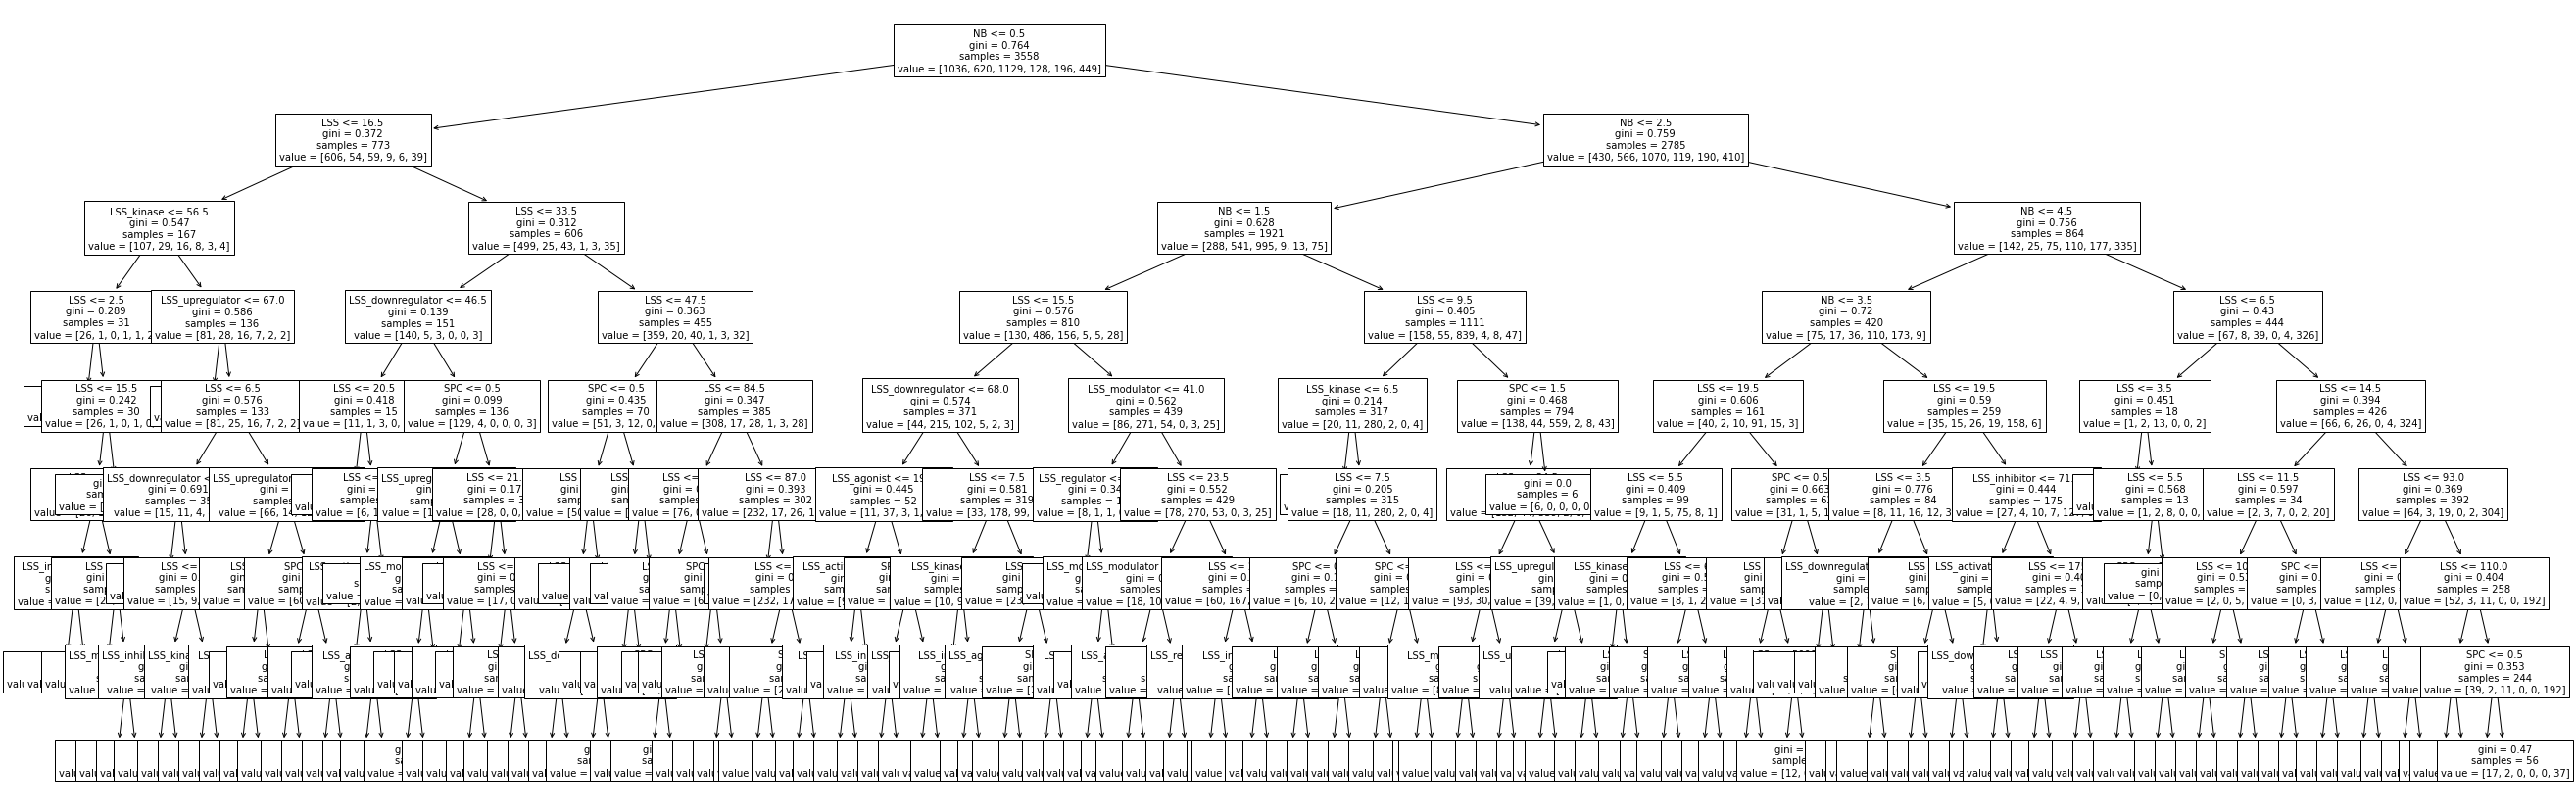

In [44]:
if NAIVE_BAYES_WITH_TREE in val_prediction_result: 
    plot_tree(val_prediction_result[NAIVE_BAYES_WITH_TREE]["m"])

## Test 

In [45]:
df_test = load_valtest_pred(local_test_prediction_file)


print_report_original(df_test, "y_raw", test_gold_file )


Running command
java -cp ../thirdparty/bc6chemprot_eval.jar org.biocreative.tasks.chemprot.main.Main -TP TRUE -FP TRUE -FN TRUE /var/folders/7v/5_mr86mx7l9g94fxzdpdx0nw0000gn/T/tmpowuzrtm_ temp/prediction/chemprot_test_gold_standard.tsv

The file:
	./out/eval.txt
was successfully created.

The file:
	./out/tp.txt
was successfully created.

The file:
	./out/fp.txt
was successfully created.

The file:
	./out/fn.txt
was successfully created.

['\n', 'Total annotations: 3458\n', 'Total predictions: 3726\n', 'TP: 2853\n', 'FN: 605\n', 'FP: 873\n', 'Precision: 0.7657004830917874\n', 'Recall: 0.8250433776749566\n', 'F-score: 0.7942650334075724']


c,FN,FP,TP,P,R,F
y,,,,,,
CPR:3,152.0,245.0,513.0,0.676781,0.771429,0.721012
CPR:4,262.0,306.0,1399.0,0.820528,0.842264,0.831254
CPR:5,37.0,30.0,158.0,0.840426,0.810256,0.825065
CPR:6,48.0,49.0,245.0,0.833333,0.836177,0.834753
CPR:9,106.0,196.0,538.0,0.732970,0.835404,0.780842
total,605.0,826.0,2853.0,0.775482,0.825043,0.799496


In [46]:
l = 'CPR:3'
tp = df_test.query(f"y_raw=='{l}' and gold_raw=='{l}'").shape[0]
fp = df_test.query(f"y_raw=='{l}' and gold_raw!='{l}'").shape[0]
fn = df_test.query(f"y_raw!='{l}' and gold_raw=='{l}'").shape[0]


fn, fp, tp

(152, 256, 515)

In [47]:
df_test = load_valtest_pred(local_test_prediction_file)

print_report(df_test["gold"],df_test["y"], labels=pos_labels)

,precision,recall,f1-score,support
1,0.667964,0.772114,0.716273,667.0
2,0.814493,0.842831,0.828420,1667.0
3,0.811224,0.803030,0.807107,198.0
4,0.816667,0.836177,0.826307,293.0
5,0.732970,0.835404,0.780842,644.0
micro avg,0.768116,0.825022,0.795552,3469.0
macro avg,0.768664,0.817911,0.791790,3469.0
weighted avg,0.771182,0.825022,0.796629,3469.0


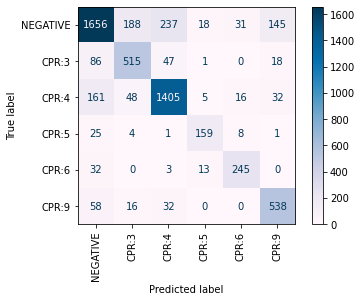

In [48]:
plot_confusionmatrix(df_test["gold"],df_test["y"] )

In [49]:
df_test["abstract_id"].shape, df_test["abstract_id"].nunique()

((5744,), 620)

### Predict Test on Test GT fit

In [50]:
df_test = load_valtest_pred(local_test_prediction_file)


result_test_gt = train_and_predict_all_classifiers(df_test, min_df=1)



print_report_all_classifiers(df_test["gold"], result_test_gt, labels=pos_labels)



Training Naive Bayes
Max words :  2736
Training Naive Bayes + Tree
\begin{tabular}{llrrrr}
\toprule
             model &        index & precision & recall & f1-score & support \\
\midrule
       Naive Bayes &            1 &      59.6 &   52.8 &     56.0 &     667 \\
       Naive Bayes &            2 &      68.9 &   72.6 &     70.7 &    1667 \\
       Naive Bayes &            3 &      71.1 &   27.3 &     39.4 &     198 \\
       Naive Bayes &            4 &      60.0 &   17.4 &     27.0 &     293 \\
       Naive Bayes &            5 &      69.2 &   45.8 &     55.1 &     644 \\
       Naive Bayes &    micro avg &      66.9 &   56.6 &     61.3 &    3469 \\
       Naive Bayes &    macro avg &      65.8 &   43.2 &     49.6 &    3469 \\
       Naive Bayes & weighted avg &      66.5 &   56.6 &     59.5 &    3469 \\
Naive Bayes + Tree &            1 &      48.9 &   64.2 &     55.5 &     667 \\
Naive Bayes + Tree &            2 &      67.1 &   72.6 &     69.8 &    1667 \\
Naive Bayes + Tree &  

,model,index,precision,recall,f1-score,support
1,Naive Bayes,1,0.595601,0.527736,0.559618,667.0
2,Naive Bayes,2,0.689066,0.725855,0.706982,1667.0
3,Naive Bayes,3,0.710526,0.272727,0.394161,198.0
4,Naive Bayes,4,0.600000,0.174061,0.269841,293.0
5,Naive Bayes,5,0.692488,0.458075,0.551402,644.0
micro avg,Naive Bayes,micro avg,0.668712,0.565581,0.612838,3469.0
macro avg,Naive Bayes,macro avg,0.657536,0.431691,0.496401,3469.0
weighted avg,Naive Bayes,weighted avg,0.665433,0.565581,0.594988,3469.0
1,Naive Bayes + Tree,1,0.489143,0.641679,0.555123,667.0
2,Naive Bayes + Tree,2,0.671286,0.726455,0.697782,1667.0


In [51]:
result_train_predict_test_gt = predict_all_classifiers(df_test, train_result)

print_report_all_classifiers(df_test["gold"], result_train_predict_test_gt,  all_labels)





\begin{tabular}{llrrrr}
\toprule
             model &        index & precision & recall & f1-score & support \\
\midrule
       Naive Bayes &            0 &      61.4 &   43.2 &     50.7 &    2275 \\
       Naive Bayes &            1 &      51.3 &   31.5 &     39.0 &     667 \\
       Naive Bayes &            2 &      39.7 &   81.3 &     53.4 &    1667 \\
       Naive Bayes &            3 &      45.0 &    4.5 &      8.3 &     198 \\
       Naive Bayes &            4 &      46.3 &    6.5 &     11.4 &     293 \\
       Naive Bayes &            5 &      61.4 &   25.2 &     35.7 &     644 \\
       Naive Bayes &     accuracy &      47.7 &   47.7 &     47.7 &       0 \\
       Naive Bayes &    macro avg &      50.9 &   32.0 &     33.1 &    5744 \\
       Naive Bayes & weighted avg &      52.6 &   47.7 &     45.0 &    5744 \\
Naive Bayes + Tree &            0 &      56.9 &   58.3 &     57.6 &    2275 \\
Naive Bayes + Tree &            1 &      39.5 &   30.3 &     34.3 &     667 \\
Naive Baye

,model,index,precision,recall,f1-score,support
0,Naive Bayes,0,0.614375,0.432088,0.507355,2275.000000
1,Naive Bayes,1,0.513447,0.314843,0.390335,667.000000
2,Naive Bayes,2,0.397361,0.812837,0.533780,1667.000000
3,Naive Bayes,3,0.450000,0.045455,0.082569,198.000000
4,Naive Bayes,4,0.463415,0.064846,0.113772,293.000000
5,Naive Bayes,5,0.613636,0.251553,0.356828,644.000000
accuracy,Naive Bayes,accuracy,0.476671,0.476671,0.476671,0.476671
macro avg,Naive Bayes,macro avg,0.508706,0.320270,0.330773,5744.000000
weighted avg,Naive Bayes,weighted avg,0.526225,0.476671,0.449839,5744.000000
0,Naive Bayes + Tree,0,0.569284,0.583297,0.576205,2275.000000


In [52]:
result_train_predict_test_gt = predict_all_classifiers(df_test, train_result)

print_report_all_classifiers(df_test["y"], result_train_predict_test_gt,  all_labels)



\begin{tabular}{llrrrr}
\toprule
             model &        index & precision & recall & f1-score & support \\
\midrule
       Naive Bayes &            0 &      59.9 &   47.5 &     53.0 &    2018 \\
       Naive Bayes &            1 &      56.5 &   30.0 &     39.2 &     771 \\
       Naive Bayes &            2 &      41.7 &   82.5 &     55.4 &    1725 \\
       Naive Bayes &            3 &      45.0 &    4.6 &      8.3 &     196 \\
       Naive Bayes &            4 &      46.3 &    6.3 &     11.1 &     300 \\
       Naive Bayes &            5 &      67.4 &   24.3 &     35.7 &     734 \\
       Naive Bayes &     accuracy &      49.1 &   49.1 &     49.1 &       0 \\
       Naive Bayes &    macro avg &      52.8 &   32.5 &     33.8 &    5744 \\
       Naive Bayes & weighted avg &      53.7 &   49.1 &     45.9 &    5744 \\
Naive Bayes + Tree &            0 &      52.6 &   60.7 &     56.3 &    2018 \\
Naive Bayes + Tree &            1 &      40.9 &   27.1 &     32.6 &     771 \\
Naive Baye

,model,index,precision,recall,f1-score,support
0,Naive Bayes,0,0.598750,0.474727,0.529574,2018.000000
1,Naive Bayes,1,0.564792,0.299611,0.391525,771.000000
2,Naive Bayes,2,0.417302,0.824928,0.554236,1725.000000
3,Naive Bayes,3,0.450000,0.045918,0.083333,196.000000
4,Naive Bayes,4,0.463415,0.063333,0.111437,300.000000
5,Naive Bayes,5,0.674242,0.242507,0.356713,734.000000
accuracy,Naive Bayes,accuracy,0.490599,0.490599,0.490599,0.490599
macro avg,Naive Bayes,macro avg,0.528084,0.325171,0.337803,5744.000000
weighted avg,Naive Bayes,weighted avg,0.537203,0.490599,0.459296,5744.000000
0,Naive Bayes + Tree,0,0.525526,0.607037,0.563348,2018.000000


In [53]:
df_test_filter = df_test\
                    .pipe(add_span_genes_chem)\
                    .pipe(filter_include_min_word_len)


result_train_filter_predict_test_filter_gt = predict_all_classifiers(df_test_filter, train_result_filter)

print_report_all_classifiers(df_test_filter["y"], result_train_filter_predict_test_filter_gt,  all_labels)






\begin{tabular}{llrrrr}
\toprule
             model &        index & precision & recall & f1-score & support \\
\midrule
       Naive Bayes &            0 &      62.4 &   59.6 &     61.0 &    1395 \\
       Naive Bayes &            1 &      50.1 &   34.3 &     40.7 &     502 \\
       Naive Bayes &            2 &      50.9 &   77.6 &     61.5 &    1182 \\
       Naive Bayes &            3 &      50.0 &    6.2 &     11.1 &      96 \\
       Naive Bayes &            4 &      37.5 &    3.0 &      5.6 &     100 \\
       Naive Bayes &            5 &      67.9 &   31.5 &     43.0 &     410 \\
       Naive Bayes &     accuracy &      55.8 &   55.8 &     55.8 &       0 \\
       Naive Bayes &    macro avg &      53.1 &   35.4 &     37.1 &    3685 \\
       Naive Bayes & weighted avg &      56.7 &   55.8 &     53.6 &    3685 \\
Naive Bayes + Tree &            0 &      51.3 &   64.6 &     57.2 &    1395 \\
Naive Bayes + Tree &            1 &      39.9 &   21.5 &     27.9 &     502 \\
Naive Baye

,model,index,precision,recall,f1-score,support
0,Naive Bayes,0,0.624343,0.595699,0.609685,1395.000000
1,Naive Bayes,1,0.501458,0.342629,0.407101,502.000000
2,Naive Bayes,2,0.509162,0.775804,0.614817,1182.000000
3,Naive Bayes,3,0.500000,0.062500,0.111111,96.000000
4,Naive Bayes,4,0.375000,0.030000,0.055556,100.000000
5,Naive Bayes,5,0.678947,0.314634,0.430000,410.000000
accuracy,Naive Bayes,accuracy,0.558480,0.558480,0.558480,0.558480
macro avg,Naive Bayes,macro avg,0.531485,0.353544,0.371378,3685.000000
weighted avg,Naive Bayes,weighted avg,0.566726,0.558480,0.535715,3685.000000
0,Naive Bayes + Tree,0,0.513390,0.645878,0.572063,1395.000000


In [54]:

result_train_filter_predict_test_gt = predict_all_classifiers(df_test, train_result_filter)

print_report_all_classifiers(df_test["y"], result_train_filter_predict_test_gt,  all_labels)





\begin{tabular}{llrrrr}
\toprule
             model &        index & precision & recall & f1-score & support \\
\midrule
       Naive Bayes &            0 &      58.1 &   47.7 &     52.4 &    2018 \\
       Naive Bayes &            1 &      55.0 &   27.9 &     37.0 &     771 \\
       Naive Bayes &            2 &      40.9 &   82.1 &     54.6 &    1725 \\
       Naive Bayes &            3 &      50.0 &    3.1 &      5.8 &     196 \\
       Naive Bayes &            4 &      44.4 &    1.3 &      2.6 &     300 \\
       Naive Bayes &            5 &      68.9 &   19.9 &     30.9 &     734 \\
       Naive Bayes &     accuracy &      47.9 &   47.9 &     47.9 &       0 \\
       Naive Bayes &    macro avg &      52.9 &   30.3 &     30.5 &    5744 \\
       Naive Bayes & weighted avg &      52.9 &   47.9 &     44.0 &    5744 \\
Naive Bayes + Tree &            0 &      46.5 &   67.0 &     54.9 &    2018 \\
Naive Bayes + Tree &            1 &      42.5 &   21.3 &     28.3 &     771 \\
Naive Baye

,model,index,precision,recall,f1-score,support
0,Naive Bayes,0,0.580918,0.476710,0.523680,2018.000000
1,Naive Bayes,1,0.549872,0.278859,0.370052,771.000000
2,Naive Bayes,2,0.408776,0.820870,0.545770,1725.000000
3,Naive Bayes,3,0.500000,0.030612,0.057692,196.000000
4,Naive Bayes,4,0.444444,0.013333,0.025890,300.000000
5,Naive Bayes,5,0.688679,0.198910,0.308668,734.000000
accuracy,Naive Bayes,accuracy,0.478586,0.478586,0.478586,0.478586
macro avg,Naive Bayes,macro avg,0.528782,0.303216,0.305292,5744.000000
weighted avg,Naive Bayes,weighted avg,0.528936,0.478586,0.440318,5744.000000
0,Naive Bayes + Tree,0,0.465428,0.670466,0.549442,2018.000000


### Predict Test on Test Prediction fit 

In [55]:
df_test_prediction = load_valtest_pred(local_test_prediction_file)

result_test_bp = train_and_predict_all_classifiers(df_test_prediction, min_df=1)

#plot_tree(result_test_bp[NAIVE_BAYES_WITH_TREE]["m"])


print_report_all_classifiers(df_test_prediction["y"], result_test_bp,  pos_labels)

print_report_all_classifiers(df_test_prediction["y"], result_test_bp,  all_labels)




Training Naive Bayes
Max words :  2736
Training Naive Bayes + Tree
\begin{tabular}{llrrrr}
\toprule
             model &        index & precision & recall & f1-score & support \\
\midrule
       Naive Bayes &            1 &      81.7 &   62.6 &     70.9 &     771 \\
       Naive Bayes &            2 &      78.2 &   79.7 &     78.9 &    1725 \\
       Naive Bayes &            3 &      89.5 &   34.7 &     50.0 &     196 \\
       Naive Bayes &            4 &      87.1 &   24.7 &     38.4 &     300 \\
       Naive Bayes &            5 &      89.9 &   52.2 &     66.0 &     734 \\
       Naive Bayes &    micro avg &      81.2 &   63.9 &     71.5 &    3726 \\
       Naive Bayes &    macro avg &      85.3 &   50.8 &     60.9 &    3726 \\
       Naive Bayes & weighted avg &      82.6 &   63.9 &     70.0 &    3726 \\
Naive Bayes + Tree &            1 &      62.3 &   70.7 &     66.2 &     771 \\
Naive Bayes + Tree &            2 &      73.3 &   76.6 &     74.9 &    1725 \\
Naive Bayes + Tree &  

,model,index,precision,recall,f1-score,support
0,Naive Bayes,0,0.626690,0.872646,0.729495,2018.000000
1,Naive Bayes,1,0.817259,0.626459,0.709251,771.000000
2,Naive Bayes,2,0.782460,0.796522,0.789428,1725.000000
3,Naive Bayes,3,0.894737,0.346939,0.500000,196.000000
4,Naive Bayes,4,0.870588,0.246667,0.384416,300.000000
5,Naive Bayes,5,0.899061,0.521798,0.660345,734.000000
accuracy,Naive Bayes,accuracy,0.721274,0.721274,0.721274,0.721274
macro avg,Naive Bayes,macro avg,0.815133,0.568505,0.628822,5744.000000
weighted avg,Naive Bayes,weighted avg,0.755739,0.721274,0.710086,5744.000000
0,Naive Bayes + Tree,0,0.758259,0.716551,0.736815,2018.000000


In [56]:
p1 = get_top_discrimintary_keywords(result_test_bp[NAIVE_BAYES]["m"],0)
p2 = get_top_discrimintary_keywords(train_result[NAIVE_BAYES]["m"],0)

kl_divergence(p1,p2)

0.18383934453471565

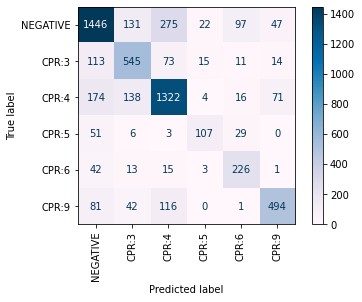

In [57]:
if NAIVE_BAYES_WITH_TREE in result_test_bp:
    df_test_prediction["shortcut_pred_nbt"] = result_test_bp[NAIVE_BAYES_WITH_TREE]["predictions"]
    print_report(df_test_prediction.query("y == gold")["y"], df_test_prediction.query("y == gold")["shortcut_pred_nbt"], all_labels)
    plot_confusionmatrix(df_test_prediction["y"], df_test_prediction["shortcut_pred_nbt"])

## Test BP 

In [58]:
result_train_predict_test_bp = predict_all_classifiers(df_test_prediction, train_result)

print_report_all_classifiers(df_test_prediction["y"], result_train_predict_test_bp,  all_labels)





\begin{tabular}{llrrrr}
\toprule
             model &        index & precision & recall & f1-score & support \\
\midrule
       Naive Bayes &            0 &      59.9 &   47.5 &     53.0 &    2018 \\
       Naive Bayes &            1 &      56.5 &   30.0 &     39.2 &     771 \\
       Naive Bayes &            2 &      41.7 &   82.5 &     55.4 &    1725 \\
       Naive Bayes &            3 &      45.0 &    4.6 &      8.3 &     196 \\
       Naive Bayes &            4 &      46.3 &    6.3 &     11.1 &     300 \\
       Naive Bayes &            5 &      67.4 &   24.3 &     35.7 &     734 \\
       Naive Bayes &     accuracy &      49.1 &   49.1 &     49.1 &       0 \\
       Naive Bayes &    macro avg &      52.8 &   32.5 &     33.8 &    5744 \\
       Naive Bayes & weighted avg &      53.7 &   49.1 &     45.9 &    5744 \\
Naive Bayes + Tree &            0 &      52.6 &   60.7 &     56.3 &    2018 \\
Naive Bayes + Tree &            1 &      40.9 &   27.1 &     32.6 &     771 \\
Naive Baye

,model,index,precision,recall,f1-score,support
0,Naive Bayes,0,0.598750,0.474727,0.529574,2018.000000
1,Naive Bayes,1,0.564792,0.299611,0.391525,771.000000
2,Naive Bayes,2,0.417302,0.824928,0.554236,1725.000000
3,Naive Bayes,3,0.450000,0.045918,0.083333,196.000000
4,Naive Bayes,4,0.463415,0.063333,0.111437,300.000000
5,Naive Bayes,5,0.674242,0.242507,0.356713,734.000000
accuracy,Naive Bayes,accuracy,0.490599,0.490599,0.490599,0.490599
macro avg,Naive Bayes,macro avg,0.528084,0.325171,0.337803,5744.000000
weighted avg,Naive Bayes,weighted avg,0.537203,0.490599,0.459296,5744.000000
0,Naive Bayes + Tree,0,0.525526,0.607037,0.563348,2018.000000


## Large scale high quality

In [59]:
df_highquality = load_valtest_pred(local_highquality_file)\
                .pipe(add_span_genes_chem)\
               # .pipe(filter_include_max_word_len, 19)

In [60]:
result_highquality_bp = train_and_predict_all_classifiers(df_highquality, min_df=1)
print_report_all_classifiers(df_highquality["y"], result_highquality_bp,  all_labels)


df_highquality["nb_predictions"]=result_highquality_bp[NAIVE_BAYES]["predictions"]

Training Naive Bayes
Max words :  11871
Training Naive Bayes + Tree
\begin{tabular}{llrrrr}
\toprule
             model &        index & precision & recall & f1-score & support \\
\midrule
       Naive Bayes &            0 &      88.6 &   75.4 &     81.5 &    1000 \\
       Naive Bayes &            1 &      73.8 &   88.9 &     80.6 &    1000 \\
       Naive Bayes &            2 &      80.8 &   79.2 &     80.0 &    1000 \\
       Naive Bayes &            3 &     100.0 &   14.3 &     25.0 &       7 \\
       Naive Bayes &            4 &      91.1 &   93.4 &     92.3 &     748 \\
       Naive Bayes &            5 &      89.7 &   85.3 &     87.4 &    1000 \\
       Naive Bayes &     accuracy &      83.9 &   83.9 &     83.9 &       0 \\
       Naive Bayes &    macro avg &      87.3 &   72.8 &     74.5 &    4755 \\
       Naive Bayes & weighted avg &      84.5 &   83.9 &     83.9 &    4755 \\
Naive Bayes + Tree &            0 &      81.4 &   79.0 &     80.2 &    1000 \\
Naive Bayes + Tree & 

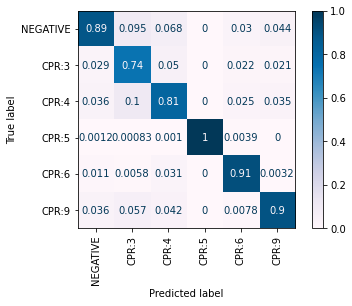

In [61]:
plot_confusionmatrix(df_highquality["y"],df_highquality["nb_predictions"], "pred")

In [62]:
df_highquality.columns

Index(['x', 'y', 'y_raw', 'abstract_id', 'abstract', 'participant1_id',
       'participant1', 'participant2_id', 'participant2', 'annotations',
       'relationship_type', 'relationship_group', 'is_eval', 'label',
       'NEGATIVE', 'CPR:3', 'CPR:4', 'CPR:5', 'CPR:6', 'CPR:9', 'prediction',
       'confidence', 'confidence_std', 'raw_confidence',
       'RecordInTrainingData', 'gold', 'gold_raw', 'x_span', 'x_span_word_len',
       'nb_predictions'],
      dtype='object')

In [63]:
df_highquality.y_raw.value_counts()

NEGATIVE    1000
CPR:3       1000
CPR:4       1000
CPR:9       1000
CPR:6        748
CPR:5          7
Name: y_raw, dtype: int64

In [64]:
df_highquality.query("x_span_word_len < 15").sample(n=5)[["x","y_raw","y","nb_predictions"]]

,x,y_raw,y,nb_predictions
1299,"CHEMIG1 has been found in many studies to improve cognitive function. However, some studies have not found this effect and others have seen nicotine-induced impairments. Systemic administration bathes the brain with drugs. However, the brain is quite intricately organized with various regions playing very different roles in the bases of cognitive function. We have examined the role of GENEIG6 in a variety of brain areas for memory. In the hippocampus and amygdala, local infusions of both _GENE_ antagonists CHEMIG4 (MLA) and _CHEMICAL_ (DHbetaE) significantly impair memory. In the current studies we locally infused acute and chronic doses of MLA and DHbetaE into the mediodorsal thalamic nucleus and tested memory function on a 16-arm radial maze. The rats also received systemic CHEMIG0 to determine the impact of more generalized CHEMIG0 effects. Since nicotinic treatments are being developed for cognitive impairment of schizophrenia, interactions were studied with the antipsychotic drug clozapine. In the acute study, the 6.75 microg/side of DHbetaE improved working memory. Co-administration of MLA reversed the DHbetaE-induced improvement. Chronic DHbetaE infusions into the mediodorsal thalamic nucleus also improved working memory. Systemic CHEMIG0 reversed this effect. CHEMIG3 had no significant interaction. Nicotinic GENEIG5 in the mediodorsal thalamic nucleus appear to play an opposite role with regard to working memory than those in the hippocampus and amygdala. Heterogeneity in response to CHEMIG2 drugs given systemically may be due to anatomically distinct nicotinic systems in the brain and their unique roles in the neural bases of cognitive function.",CPR:6,4,4
1233,"The inactivation of programmed cell death has profound effects not only on the development but also on the overall integrity of multicellular organisms. Beside developmental abnormalities, it may lead to tumorigenesis, autoimmunity, and other serious health problems. Deregulated apoptosis may also be the leading cause of cancer therapy chemoresistance. GENEIG6 family of GENEIG5 plays the key role in the initiation and execution of programmed cell death. This review gives an overview of the role of caspases, their natural modulators like IAPs, GENEIG3 and Smac/Diablo in apoptosis and upon inactivation, and also in cancer development. Besides describing the basic mechanisms governing programmed cell death, a large part of this review is dedicated to previous studies that were focused on screening tumours for mutations within GENEIG1 genes as well as their regulators. The last part of this review discusses several emerging treatments that involve modulation of GENEIG4 and their regulators. Thus, we also highlight GENEIG1 cascade modulating experimental anticancer drugs like cFLIP-antagonist CDDO-Me; GENEIG0 antagonists CHEMIG2 and ME-BS; and XIAP small molecule antagonists 1396-11, 1396-12, 1396-28, triptolide, AEG35156, _GENE_ antagonist _CHEMICAL_ and some of the direct activators of procaspase-3.",CPR:6,4,4
4463,"The introduction of direct acting antiviral agents (DAAs) will markedly change treatment options for individuals who have a chronic HCV infection. Within the next few months, licensing of two _GENE_ inhibitors (boceprevir and _CHEMICAL_ for the treatment of patients with chronic hepatitis C as part of a triple therapy with GENEIG1 and CHEMIG2 is anticipated in the USA, Europe and many other countries. Final results of pivotal phase III clinical trials in previously untreated and treatment-experienced patients with HCV genotype 1 infection were presented at the Annual Meeting of the American Association for the Study of the Liver 2010 held in Boston, MA, USA, and at the Annual Conference of the Asian Pacific Association for the Study of the Liver 2011, held in Bangkok, Thailand. This article summarizes the results of these phase III trials in consideration of accumulating data on important baseline and on-treatment predi

In [65]:
p1 = get_top_discrimintary_keywords(result_highquality_bp[NAIVE_BAYES]["m"],4)
p2 = get_top_discrimintary_keywords(train_result[NAIVE_BAYES]["m"],4)

kl_divergence(p1,p2)

0.21065911940270118

In [66]:
result_highquality_train_result =  predict_all_classifiers(df_highquality, train_result)
print_report_all_classifiers(df_highquality["y"], result_highquality_train_result,  all_labels)


\begin{tabular}{llrrrr}
\toprule
             model &        index & precision & recall & f1-score & support \\
\midrule
       Naive Bayes &            0 &      31.8 &   47.6 &     38.2 &    1000 \\
       Naive Bayes &            1 &      43.2 &   52.2 &     47.3 &    1000 \\
       Naive Bayes &            2 &      39.5 &   53.6 &     45.5 &    1000 \\
       Naive Bayes &            3 &       3.4 &   28.6 &      6.2 &       7 \\
       Naive Bayes &            4 &      79.5 &   16.0 &     26.7 &     748 \\
       Naive Bayes &            5 &      64.3 &   31.4 &     42.2 &    1000 \\
       Naive Bayes &     accuracy &      41.4 &   41.4 &     41.4 &       0 \\
       Naive Bayes &    macro avg &      43.6 &   38.2 &     34.3 &    4755 \\
       Naive Bayes & weighted avg &      50.1 &   41.4 &     40.6 &    4755 \\
Naive Bayes + Tree &            0 &      32.4 &   67.5 &     43.8 &    1000 \\
Naive Bayes + Tree &            1 &      46.8 &   27.5 &     34.7 &    1000 \\
Naive Baye

,model,index,precision,recall,f1-score,support
0,Naive Bayes,0,0.318395,0.476000,0.381563,1000.000000
1,Naive Bayes,1,0.432477,0.522000,0.473040,1000.000000
2,Naive Bayes,2,0.395280,0.536000,0.455008,1000.000000
3,Naive Bayes,3,0.034483,0.285714,0.061538,7.000000
4,Naive Bayes,4,0.794702,0.160428,0.266963,748.000000
5,Naive Bayes,5,0.643443,0.314000,0.422043,1000.000000
accuracy,Naive Bayes,accuracy,0.414301,0.414301,0.414301,0.414301
macro avg,Naive Bayes,macro avg,0.436463,0.382357,0.343359,4755.000000
weighted avg,Naive Bayes,weighted avg,0.501424,0.414301,0.406262,4755.000000
0,Naive Bayes + Tree,0,0.324207,0.675000,0.438027,1000.000000


## Low quality

In [67]:
df_lowquality = load_valtest_pred(local_lowquality_file)\
                .pipe(add_span_genes_chem)\
              


In [68]:

result_lowquality_bp = train_and_predict_all_classifiers(df_lowquality, min_df=1)
print_report_all_classifiers(df_lowquality["y"], result_lowquality_bp,  all_labels)

Training Naive Bayes
Max words :  8905
Training Naive Bayes + Tree
\begin{tabular}{llrrrr}
\toprule
             model &        index & precision & recall & f1-score & support \\
\midrule
       Naive Bayes &            0 &      72.3 &   58.0 &     64.4 &    1000 \\
       Naive Bayes &            1 &      61.0 &   67.4 &     64.0 &    1000 \\
       Naive Bayes &            2 &      70.4 &   60.0 &     64.8 &    1000 \\
       Naive Bayes &            3 &      82.2 &   87.0 &     84.5 &     998 \\
       Naive Bayes &            4 &      79.5 &   90.4 &     84.6 &    1000 \\
       Naive Bayes &            5 &      70.6 &   73.8 &     72.1 &    1000 \\
       Naive Bayes &     accuracy &      72.8 &   72.8 &     72.8 &       0 \\
       Naive Bayes &    macro avg &      72.7 &   72.8 &     72.4 &    5998 \\
       Naive Bayes & weighted avg &      72.7 &   72.8 &     72.4 &    5998 \\
Naive Bayes + Tree &            0 &      65.1 &   62.2 &     63.6 &    1000 \\
Naive Bayes + Tree &  

,model,index,precision,recall,f1-score,support
0,Naive Bayes,0,0.723192,0.580000,0.643729,1000.000000
1,Naive Bayes,1,0.609955,0.674000,0.640380,1000.000000
2,Naive Bayes,2,0.704225,0.600000,0.647948,1000.000000
3,Naive Bayes,3,0.821970,0.869739,0.845180,998.000000
4,Naive Bayes,4,0.795075,0.904000,0.846046,1000.000000
5,Naive Bayes,5,0.705545,0.738000,0.721408,1000.000000
accuracy,Naive Bayes,accuracy,0.727576,0.727576,0.727576,0.727576
macro avg,Naive Bayes,macro avg,0.726660,0.727623,0.724115,5998.000000
weighted avg,Naive Bayes,weighted avg,0.726628,0.727576,0.724075,5998.000000
0,Naive Bayes + Tree,0,0.650628,0.622000,0.635992,1000.000000


In [69]:
p1 = get_top_discrimintary_keywords(result_lowquality_bp[NAIVE_BAYES]["m"],4)
p2 = get_top_discrimintary_keywords(train_result[NAIVE_BAYES]["m"],4)

kl_divergence(p1,p2)

0.4140620868885688

In [70]:
result_lowquality_train_result =  predict_all_classifiers(df_lowquality, train_result)
print_report_all_classifiers(df_lowquality["y"], result_lowquality_train_result,  all_labels)



\begin{tabular}{llrrrr}
\toprule
             model &        index & precision & recall & f1-score & support \\
\midrule
       Naive Bayes &            0 &      16.7 &   29.1 &     21.2 &    1000 \\
       Naive Bayes &            1 &      25.4 &   43.2 &     32.0 &    1000 \\
       Naive Bayes &            2 &      23.0 &   40.0 &     29.2 &    1000 \\
       Naive Bayes &            3 &      50.3 &    7.3 &     12.8 &     998 \\
       Naive Bayes &            4 &      56.0 &   12.1 &     19.9 &    1000 \\
       Naive Bayes &            5 &      47.8 &   21.7 &     29.8 &    1000 \\
       Naive Bayes &     accuracy &      25.6 &   25.6 &     25.6 &       0 \\
       Naive Bayes &    macro avg &      36.5 &   25.6 &     24.2 &    5998 \\
       Naive Bayes & weighted avg &      36.5 &   25.6 &     24.2 &    5998 \\
Naive Bayes + Tree &            0 &      17.8 &   49.2 &     26.2 &    1000 \\
Naive Bayes + Tree &            1 &      21.5 &   15.9 &     18.3 &    1000 \\
Naive Baye

,model,index,precision,recall,f1-score,support
0,Naive Bayes,0,0.166667,0.291000,0.211945,1000.000000
1,Naive Bayes,1,0.254417,0.432000,0.320237,1000.000000
2,Naive Bayes,2,0.230017,0.400000,0.292077,1000.000000
3,Naive Bayes,3,0.503448,0.073146,0.127734,998.000000
4,Naive Bayes,4,0.560185,0.121000,0.199013,1000.000000
5,Naive Bayes,5,0.477974,0.217000,0.298487,1000.000000
accuracy,Naive Bayes,accuracy,0.255752,0.255752,0.255752,0.255752
macro avg,Naive Bayes,macro avg,0.365451,0.255691,0.241582,5998.000000
weighted avg,Naive Bayes,weighted avg,0.365405,0.255752,0.241620,5998.000000
0,Naive Bayes + Tree,0,0.178261,0.492000,0.261702,1000.000000


In [71]:
get_top_discrimintary_keywords(result_lowquality_bp[NAIVE_BAYES]["m"],1)[:20]

[('_gene_', -3.922299689289378),
 ('_chemical_', -3.922299689289378),
 ('cells', -4.636649077499927),
 ('induced', -4.844602463320161),
 ('expression', -4.904128442634188),
 ('geneig0', -4.970268245138733),
 ('geneig3', -4.9904128112312005),
 ('geneig2', -5.010971538252237),
 ('cell', -5.016923936779532),
 ('geneig1', -5.031961814144073),
 ('activity', -5.107469366652218),
 ('increased', -5.157731201433106),
 ('geneig4', -5.185607570961361),
 ('chemig0', -5.196264865435349),
 ('levels', -5.221582673419639),
 ('geneig5', -5.232632509606224),
 ('chemig2', -5.240067488093742),
 ('chemig1', -5.255105365458283),
 ('activation', -5.313601572139891),
 ('chemig4', -5.317625722439616)]

## Summary of Analysis

Training Naive Bayes
Max words :  1000
Training Naive Bayes
Max words :  1000
Training Naive Bayes
Max words :  1000
Training Naive Bayes
Max words :  1000
Training Naive Bayes
Max words :  2000
Training Naive Bayes
Max words :  1279
Training Naive Bayes
Max words :  2000
Training Naive Bayes
Max words :  1279
Training Naive Bayes
Max words :  1400
Training Naive Bayes
Max words :  505
Training Naive Bayes
Max words :  1400
Training Naive Bayes
Max words :  505


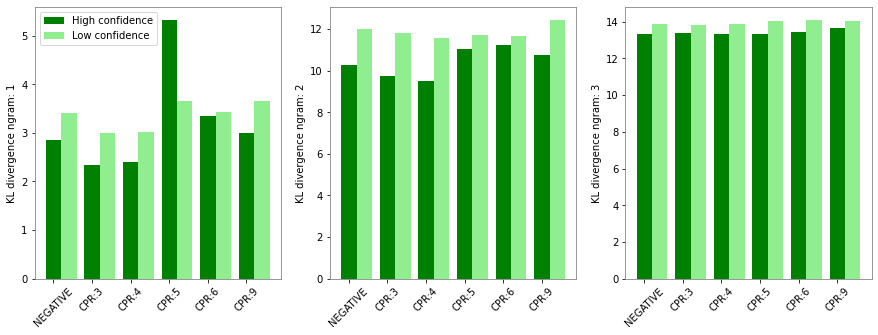

In [72]:
import numpy as np

def compute_js_divergence(p1_model_result, p2_model_result, label_names=label_names, use_common_only=False):
    result = []
    for i, l in enumerate(label_names):
        p = js_divergence(get_top_discrimintary_keywords(p1_model_result[NAIVE_BAYES]["m"],i),
                     get_top_discrimintary_keywords(p2_model_result[NAIVE_BAYES]["m"],i),
                          use_common_only=use_common_only
                     )
        result.append({
            "label_name" : l,
            "label_index" : i,
            "kl" : p
        })
    return pd.DataFrame(result)
        
def plot_divergence(df1,t1, df2, t2, ax, suffix_y_label):
    ind = np.array([float(i) for i in df1["label_index"].values] )
    width = 0.4
    
    ax.bar(ind, df1["kl"], width, color='green', label=t1)
    ax.bar(ind + width,  df2["kl"], width, color='lightgreen', label=t2)
    
    ax.legend()
    
    ax.set_xticks(df1["label_index"].values)
    ax.set_xticklabels(df1["label_name"], rotation = 45)
    
    ax.set_ylabel(f"KL divergence {suffix_y_label}")
    
    ax.spines['bottom'].set_color('grey')
    ax.spines['top'].set_color('grey') 
    ax.spines['right'].set_color('grey')
    ax.spines['left'].set_color('grey')

        

_, axes= plt.subplots(1,3, figsize=(15,5))  

classifiers = {NAIVE_BAYES}

kwargs = {
    "ngram_range":(1,1),
   "min_df": 5,
   "stop_words": 'english',
    "classifiers":classifiers,
    "classwise_vocab":False,
    "max_words_per_class" :  1000
}

ax = axes[0]
plot_divergence(compute_js_divergence(train_and_predict_all_classifiers(df_highquality, 
                                                                       **kwargs
                                                                      ), 
                                      train_and_predict_all_classifiers(df_train, 
                                                                    **kwargs
                                                                  ),
                                      use_common_only=False
                                     ),
                "High confidence", 
                compute_kl_divergence(train_and_predict_all_classifiers(df_lowquality, 
                                                                       **kwargs
                                                                      ), 
                                      train_and_predict_all_classifiers(df_train, 
                                                                   **kwargs
                                                                  ), 
                                      use_common_only=False
                                     ),
                "Low confidence",
                ax,
               "ngram: 1")
# ax = axes[1][0]
# plot_divergence(compute_kl_divergence(train_and_predict_all_classifiers(df_highquality, 
#                                                                        **kwargs
#                                                                       ), 
#                                       train_and_predict_all_classifiers(df_train, 
#                                                                     **kwargs
#                                                                   ),
#                                        use_common_only=True
#                                      ),
#                 "High confidence", 
#                 compute_kl_divergence(train_and_predict_all_classifiers(df_lowquality, 
#                                                                        **kwargs
#                                                                       ), 
#                                       train_and_predict_all_classifiers(df_train, 
#                                                                    **kwargs
#                                                                   ), 
#                                       use_common_only=True
#                                      ),
#                 "Low confidence",
#                 ax)




kwargs = {
    "ngram_range":(2,2),
    "min_df": 5,
    "stop_words":'english',
    "classifiers":classifiers,
    "classwise_vocab":False,
    "max_words_per_class" :  2000
}

ax = axes[1]
plot_divergence(compute_js_divergence(train_and_predict_all_classifiers(df_highquality, 
                                                                       **kwargs
                                                                      ), 
                                      train_and_predict_all_classifiers(df_train, 
                                                                    **kwargs
                                                                  ),
                                      use_common_only=False
                                     ),
                "High confidence", 
                compute_js_divergence(train_and_predict_all_classifiers(df_lowquality, 
                                                                       **kwargs
                                                                      ), 
                                      train_and_predict_all_classifiers(df_train, 
                                                                   **kwargs
                                                                  ),
                                       use_common_only=False
                                     ),
                "Low confidence",
                ax, "ngram: 2")

ax.legend().remove()
# ax = axes[1][1]
# plot_divergence(compute_kl_divergence(train_and_predict_all_classifiers(df_highquality, 
#                                                                        **kwargs
#                                                                       ), 
#                                       train_and_predict_all_classifiers(df_train, 
#                                                                     **kwargs
#                                                                   ),
#                                        use_common_only=True
#                                      ),
#                 "High confidence", 
#                 compute_kl_divergence(train_and_predict_all_classifiers(df_lowquality, 
#                                                                        **kwargs
#                                                                       ), 
#                                       train_and_predict_all_classifiers(df_train, 
#                                                                    **kwargs
#                                                                   ), 
#                                       use_common_only=True
#                                      ),
#                 "Low confidence",
#                 ax)
# ax.legend().remove()



kwargs = {
    "ngram_range":(3,3),
   "min_df": 5,
   "stop_words":'english',
    "classifiers":classifiers,
    "max_words_per_class" :  1400,
    "classwise_vocab":False
}

ax = axes[2]
plot_divergence(compute_js_divergence(train_and_predict_all_classifiers(df_highquality, 
                                                                       **kwargs
                                                                      ), 
                                      train_and_predict_all_classifiers(df_train, 
                                                                    **kwargs
                                                                  ),
                                       use_common_only=False
                                     ),
                "High confidence", 
                compute_js_divergence(train_and_predict_all_classifiers(df_lowquality, 
                                                                       **kwargs
                                                                      ), 
                                      train_and_predict_all_classifiers(df_train, 
                                                                   **kwargs
                                                                  ), 
                                      use_common_only=False
                                     ),
                "Low confidence",
                ax, "ngram: 3")

ax.legend().remove()


# ax = axes[1][2]
# plot_divergence(compute_kl_divergence(train_and_predict_all_classifiers(df_highquality, 
#                                                                        **kwargs
#                                                                       ), 
#                                       train_and_predict_all_classifiers(df_train, 
#                                                                     **kwargs
#                                                                   ),
#                                        use_common_only=True
#                                      ),
#                 "High confidence", 
#                 compute_kl_divergence(train_and_predict_all_classifiers(df_lowquality, 
#                                                                        **kwargs
#                                                                       ), 
#                                       train_and_predict_all_classifiers(df_train, 
#                                                                    **kwargs
#                                                                   ), 
#                                       use_common_only=True
#                                      ),
#                 "Low confidence",
#                 ax)

#ax.legend().remove()

In [73]:
from sklearn.feature_extraction.text import CountVectorizer
import warnings

def classwise_jacq(df1, df2, label_names=label_names,
                   stop_words=None, 
                   max_words_per_class=3000,
                   min_df=5,
                  ngram_range=(1,1)):
    result = []
    for i,l in enumerate(label_names):
        df1_sub = df1.query(f"y=={i}")
        df2_sub = df2.query(f"y=={i}")
        
        

        cv = CountVectorizer(stop_words=stop_words, max_features=max_words_per_class, min_df=min_df,
                             ngram_range=ngram_range,
                             analyzer='word')
        
        try:
        
            v1 = cv.fit(df1_sub["x"]).vocabulary_
            v2 = cv.fit(df2_sub["x"]).vocabulary_







            score = jaccard(v1,v2)

            result.append({

                "score" : score,
                "v1" : v1,
                "v2": v2,
                "union": set(v1).union(set(v2)),
                "intersection": set(v1).intersection(set(v2)),
                "onlyv2": set(v2)-set(v1),
                "onlyv1": set(v1)-set(v2)


            })
        except ValueError as e:
            warnings.warn(l + " - "+ str(e))
    return result
kwargs = {
    "ngram_range":(2,2),
    "min_df": 5,
    "stop_words":'english',   
    "max_words_per_class" :  2000
}




high_jq_result = classwise_jacq(df_highquality, df_train, **kwargs)
              
low_jq_result = classwise_jacq(df_lowquality, df_train, **kwargs)

/var/folders/7v/5_mr86mx7l9g94fxzdpdx0nw0000gn/T/ipykernel_27272/3022533124.py:46: UserWarning: CPR:5 - After pruning, no terms remain. Try a lower min_df or a higher max_df.
  warnings.warn(l + " - "+ str(e))


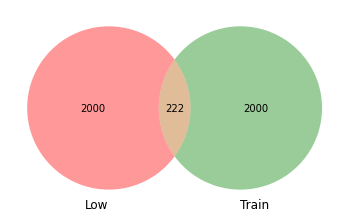

In [74]:
from matplotlib_venn import venn2

def plot_venn( score):
    venn2(subsets = (len(score[1]["v1"])
                     , len(score[1]["v2"])
                     , len(score[1]["intersection"])
                    ), 
          set_labels = ('Low', 'Train'))
    plt.show()

plot_venn(low_jq_result)

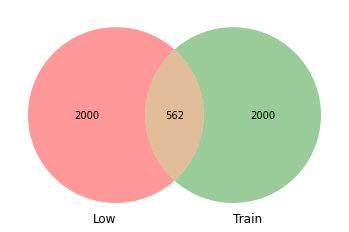

In [75]:
plot_venn(high_jq_result)

In [76]:
print(low_jq_result[0]["intersection"])

{'endothelial cells', 'cell lines', 'geneig8 activity', 'compared control', 'significantly different', 'geneig3 geneig2', 'cell types', 'membrane potential', 'inflammatory response', 'expression geneig7', 'significantly higher', 'channel blockers', 'geneig1 mrna', 'western blot', '05 observed', 'receptor binding', 'real time', 'geneig0 expression', 'increased expression', 'molecular weight', '_gene_ expression', 'geneig2 activity', 'microg kg', 'play role', 'expression geneig1', 'drinking water', 'plays important', 'induced expression', 'concentration dependent', 'taken results', 'tomography pet', 'geneig0 mrna', 'geneig6 expression', 'expression geneig3', 'activated protein', 'geneig0 activity', 'geneig4 expression', 'ic 50', 'central nervous', 'cell proliferation', 'cell death', 'cells treated', 'embryonic fibroblasts', 'geneig2 mrna', '_gene_ mrna', 'mechanisms underlying', 'geneig1 activity', 'polymerase chain', 'significantly increased', 'mode action', 'cell growth', 'significant 

In [77]:
for i in result:
    print(i["label"], i["score"])
    print(i["score"])


NameError: name 'result' is not defined

## Latex results

In [ ]:
def prepare_latex(meta_dict_df, index_filter=None):
    result = []
    model_names = {NAIVE_BAYES: "NB",
                  NAIVE_BAYES_WITH_TREE:"NT",
                  TREE : "T"
    }

    for item in meta_dict_df:
        df= item.pop("df")
        if index_filter:
            df = df[df["index"].isin(index_filter)].copy(deep=True)
        df["model"] = df["model"].apply(lambda x: model_names[x])
        for i, meta in enumerate(item["meta"]):
            df.insert(i, meta["name"], meta["value"])
        result.append(df)
        
    df_summ = pd.concat(result)
    df_summ = df_summ.drop("index", axis=1)
    
    return df_summ
    
df_summ_train = print_report_all_classifiers(df_train["gold"], train_result, all_labels)

df_summ_test_bp = print_report_all_classifiers(df_test_prediction["y"], result_test_bp, all_labels)

df_summ_test_gt = print_report_all_classifiers(df_test["gold"], result_test_gt, all_labels)



df_summ = prepare_latex ([
    {"df": df_summ_train, "meta":[{ "name": "dataset" , "value": "CHM TR"}, { "name": "T" , "value": "GT"}]},
    {"df": df_summ_test_gt, "meta":[{ "name": "dataset" , "value": "CHM TS"}, { "name": "T" , "value": "GT"}]},
    {"df": df_summ_test_bp, "meta":[{ "name": "dataset" , "value": "CHM TS"}, { "name": "T" , "value": "BP"}]},
                ]
              )

print(df_summ.to_latex(index=False, formatters = {"precision": float_percent_format, "recall":float_percent_format, "f1-score":float_percent_format,"support":int_format}))

In [ ]:
df_summ_trainfit_test_bp = print_report_all_classifiers(df_test_prediction["y"], result_train_predict_test_bp,  all_labels)
df_summ_trainfit_test_gt = print_report_all_classifiers(df_test["gold"], result_train_predict_test_gt,  all_labels)

df_summ_train = print_report_all_classifiers(df_train["y"], train_result, all_labels)





df_summ_neg = prepare_latex ([
                    {"df": df_summ_train, "meta":[{ "name": "dataset" , "value": "CHM TR"}, { "name": "T" , "value": "GT"}]},


                {"df": df_summ_trainfit_test_gt, "meta":[{ "name": "dataset" , "value": "CHM TS"}, { "name": "T" , "value": "GT"}]},
                {"df": df_summ_trainfit_test_bp, "meta":[{ "name": "dataset" , "value": "CHM TS"}, { "name": "T" , "value": "BP"}]},
               



                ],
    index_filter=[0]
              )

print("**0***")
print(df_summ_neg.to_latex(index=False, formatters = {"precision": float_percent_format, "recall":float_percent_format, "f1-score":float_percent_format,"support":int_format}))

df_summ_phos = prepare_latex ([
                        {"df": df_summ_train, "meta":[{ "name": "dataset" , "value": "PTM TR"}, { "name": "T" , "value": "GT"}]},


                {"df": df_summ_trainfit_test_gt, "meta":[{ "name": "dataset" , "value": "PTM TS"}, { "name": "T" , "value": "GT"}]},
                {"df": df_summ_trainfit_test_bp, "meta":[{ "name": "dataset" , "value": "PTM TS"}, { "name": "T" , "value": "BP"}]},
             




                ],
    index_filter=[2]
              )

print("**2***")

print(df_summ_phos.to_latex(index=False, formatters = {"precision": float_percent_format, "recall":float_percent_format, "f1-score":float_percent_format,"support":int_format}))

In [ ]:
print(len(result_test_bp[NAIVE_BAYES]["m"].vocab))

In [ ]:
def prepare_latex_2(meta_dict_df, index_filter=None):
    result = []
    model_names = {NAIVE_BAYES: "NB",
                  NAIVE_BAYES_WITH_TREE:"NBT",
                  TREE : "T"
    }

    for item in meta_dict_df:
        df= item.pop("df")
        df = df.copy(deep=True)
        if index_filter:
            df = df[df["index"].isin(index_filter)].copy(deep=True)
        df["model"] = df["model"].apply(lambda x: model_names[x])
        for i, meta in enumerate(item["meta"]):
            df.insert(i, meta["name"], meta["value"])
        result.append(df)
    df_summ = pd.concat(result)
    df_summ["index"] = df_summ["index"].apply(lambda x: label_names[int(x)] if isint(x) else x )
    
    return df_summ
    
df_summ_train = print_report_all_classifiers(df_train["gold"], train_result, all_labels)

df_summ_test_bp = print_report_all_classifiers(df_test_prediction["y"], result_test_bp, all_labels)

df_summ_test_gt = print_report_all_classifiers(df_test["gold"], result_test_gt, all_labels)



df_summ = prepare_latex_2 ([
    {"df": df_summ_train, "meta":[{ "name": "dataset" , "value": "CHM TR"}, { "name": "T" , "value": "GT"}]},
    {"df": df_summ_test_gt, "meta":[{ "name": "dataset" , "value": "CHM TS"}, { "name": "T" , "value": "GT"}]},
    {"df": df_summ_test_bp, "meta":[{ "name": "dataset" , "value": "CHM TS"}, { "name": "T" , "value": "BP"}]},
                ]
              )

print(df_summ.to_latex(index=False, formatters = {"precision": float_percent_format, "recall":float_percent_format, "f1-score":float_percent_format,"support":int_format}))